# Problem 1

In [1]:
#hw1 – problem 1
#figure out the effective wavelengths of filters
#read the filter files, guess the units, compute lambda_eff, and dump a table

import numpy as np
import pandas as pd
import os, glob

#don’t actually need this here but maybe for future use
angstrom_to_cm = 1e-8

#read a filter file, no matter if it’s 2 or 3+ columns
#(maybe we have an index in front, maybe not)
def load_filter_any(path):
    arr = np.loadtxt(path, comments=('#','%','//'))  #ignore any comments we get
    if arr.ndim == 1:  #if it’s just one line, make it look like a table
        arr = arr.reshape(1, -1)
    ncol = arr.shape[1]

    if ncol >= 3:
        lam_raw = arr[:, 1].astype(float)  #second col = lambda
        s = arr[:, 2].astype(float)  #third col = throughput
        fmt = "idx+lambda+s"
    elif ncol == 2:
        lam_raw = arr[:, 0].astype(float)  #first col = lambda
        s = arr[:, 1].astype(float)  #second col = throughput
        fmt = "lambda+s"
    else:
        raise ValueError(f"uhh weird column count: {ncol}")

    #throw away bad values
    m = np.isfinite(lam_raw) & np.isfinite(s) & (lam_raw > 0) & (s >= 0)
    lam_raw, s = lam_raw[m], s[m]

    #preview the first few rows
    preview = np.column_stack([lam_raw[:6], s[:6]])
    return lam_raw, s, fmt, preview


#figure out units:
#if it looks like microns -> convert to angstrom
#if it looks like nanometer -> convert to angstrom
#else -> assume already angstrom
def infer_units_and_to_angstrom(lam_raw):
    if lam_raw.size == 0:
        return lam_raw, "??"
    med = float(np.nanmedian(lam_raw))
    if not np.isfinite(med) or med <= 0:
        return lam_raw, "??"  #can’t tell
    if 0.2 <= med < 30.0:  #0.2–30 micrometer range
        return lam_raw * 1e4, "micrometer->angstrom"
    elif 200.0 <= med < 3000.0:  #200–3000 nanometer range
        return lam_raw * 10.0, "nanometer->angstrom"
    else:  #already angstrom
        return lam_raw, "angstrom"


#now, let's calculate our effective wavelength
#basically average lambda but weighted by the filter shape
#(using Fukugita+96 equation)
def lambda_eff_from_lambda(lam_a, s):
    lam_a = np.asarray(lam_a, float)
    s = np.asarray(s, float)
    if lam_a.size < 3 or np.all(s == 0):
        return np.nan

    lnlam = np.log(lam_a)
    num = np.trapz(s * lnlam, lnlam)  #numerator
    den = np.trapz(s, lnlam)  #denominator

    if den <= 0 or not np.isfinite(den):
        return np.nan
    return float(np.exp(num / den))


#now we loop: go through all filter files in the folder,
#compute lambda_eff, throw results into a DataFrame
def compute_folder(folder):
    rows = []
    for path in glob.glob(os.path.join(folder, "*.dat")):
        base = os.path.basename(path)
        name = os.path.splitext(base)[0]

        try:
            lam_raw, s, fmt, preview = load_filter_any(path)
            lam_a, unit_tag = infer_units_and_to_angstrom(lam_raw)

            #sort by lambda just in case file is messy
            order = np.argsort(lam_a)
            lam_a, s = lam_a[order], s[order]

            lam_eff_a = lambda_eff_from_lambda(lam_a, s)

            rows.append((name, base, lam_eff_a, lam_eff_a/1e4 if np.isfinite(lam_eff_a) else np.nan, unit_tag, fmt))
        except Exception as e:
            rows.append((name, base, np.nan, np.nan, "oops", f"error: {e}"))  #just note the error

    df = pd.DataFrame(rows, columns=["filter","file","lambda_eff_angstrom","lambda_eff_micron","unit_detected","format_detected"])

    #put ubvri jhk at the top
    order_pref = {k:i for i,k in enumerate(["U","B","V","R","I","J","H","K"])}
    def stem(s): return str(s).split("_")[0].upper()
    df["__ord__"] = df["filter"].map(lambda s: order_pref.get(stem(s), 999))
    df = df.sort_values(["__ord__", "filter"]).drop(columns="__ord__").reset_index(drop=True)
    return df


#now we call our functions
folder = r"C:\Users\tklea\Tufts Masters\Courses\Galactic Astrpohysics\HW1\filters"

df = compute_folder(folder)
print("\n=== lambda_eff results ===")
print(df.to_string(index=False))

#save table into "problem1" folder
hw1_dir = os.path.dirname(folder)
problem1_dir = os.path.join(hw1_dir, "Problem1")
os.makedirs(problem1_dir, exist_ok=True)

out_csv = os.path.join(problem1_dir, "effectivewavelengths.csv")
df.to_csv(out_csv, index=False)
print(f"\nSaved results to: {out_csv}")



=== lambda_eff results ===
          filter                 file  lambda_eff_angstrom  lambda_eff_micron unit_detected format_detected
 U_MaizApellaniz  U_MaizApellaniz.dat          3572.720973           0.357272      angstrom    idx+lambda+s
 B_MaizApellaniz  B_MaizApellaniz.dat          4345.237340           0.434524      angstrom    idx+lambda+s
 V_MaizApellaniz  V_MaizApellaniz.dat          5457.264027           0.545726      angstrom    idx+lambda+s
R_JohnsonCousins R_JohnsonCousins.dat          6418.338290           0.641834      angstrom    idx+lambda+s
I_JohnsonCousins I_JohnsonCousins.dat          7853.892916           0.785389      angstrom    idx+lambda+s
         J_2mass          J_2mass.dat         12322.292635           1.232229      angstrom    idx+lambda+s
         H_2mass          H_2mass.dat         16420.041247           1.642004      angstrom    idx+lambda+s
         K_2mass          K_2mass.dat         21566.876703           2.156688      angstrom    idx+lambda+s


# Problem 2

In [2]:
#hw1 – problem 2
#goal: vega -> ab corrections per filter, then merge onto problem 1 table

import numpy as np
import pandas as pd
import os, glob

#p1 helpers
def load_filter_any(path):
    arr = np.loadtxt(path, comments=('#','%','//'))  #read 2-col or 3+-col filters
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    ncol = arr.shape[1]
    if ncol >= 3:
        lam_raw = arr[:, 1].astype(float)  #wavelength
        s = arr[:, 2].astype(float)  #throughput
    elif ncol == 2:
        lam_raw = arr[:, 0].astype(float)  #wavelength
        s = arr[:, 1].astype(float)  #throughput
    else:
        raise ValueError(f"need 2+ numeric columns, got {ncol}")
    m = np.isfinite(lam_raw) & np.isfinite(s) & (lam_raw > 0) & (s >= 0)  #basic cleanup
    return lam_raw[m], s[m]

def infer_units_and_to_angstrom(lam_raw):
    if lam_raw.size == 0:
        return lam_raw, "??"
    med = float(np.nanmedian(lam_raw))
    if not np.isfinite(med) or med <= 0:
        return lam_raw, "??"
    if 0.2 <= med < 30.0:
        return lam_raw * 1e4, "micrometer->angstrom"  #micrometers -> angstrom
    elif 200.0 <= med < 3000.0:
        return lam_raw * 10.0, "nanometer->angstrom"  #nanometers -> angstrom
    else:
        return lam_raw, "angstrom"  #already angstrom

def sort_by_lambda(lam_a, s):
    o = np.argsort(lam_a)  #sort both arrays together
    return lam_a[o], s[o]

def stem_band(name):
    return str(name).split("_")[0].upper()  #'V_Maiz...' -> 'V'

#constants
c_cms = 2.99792458e10  #cm/s
angstrom_to_cm = 1e-8  #angstrom -> cm
micron_to_cm = 1e-4  #micrometer -> cm

vega_wavelength_in_micron = False  #flip true if vega lambda is in micrometers
vega_flux_is_fnu = False  #flip true if vega flux column is already f_nu

#vega and ab photometry
def load_vega(path):
    dat = np.loadtxt(path, comments=('#','%','//'))  #two cols: lambda, flux
    lam = np.asarray(dat[:, 0], float)
    flux = np.asarray(dat[:, 1], float)
    lam_cm = lam * (micron_to_cm if vega_wavelength_in_micron else angstrom_to_cm)  #wavelength to cm
    nu = c_cms / lam_cm  #frequency in hz
    if vega_flux_is_fnu:
        f_nu = flux.astype(float)  #already f_nu
    else:
        factor = (1.0 / micron_to_cm) if vega_wavelength_in_micron else (1.0 / angstrom_to_cm)  #per cm
        f_lambda_per_cm = flux * factor  #convert f_lambda to per cm
        f_nu = f_lambda_per_cm * (lam_cm**2) / c_cms  #f_nu = f_lambda * lambda^2 / c
    m = np.isfinite(nu) & np.isfinite(f_nu) & (nu > 0) & (f_nu >= 0)  #clean
    nu, f_nu = nu[m], f_nu[m]
    o = np.argsort(nu)  #sort by frequency
    return nu[o], f_nu[o]

def vega_ab_through_filter(lam_a, s, nu_v, fnu_v):
    if lam_a.size < 3 or np.all(s == 0):
        return np.nan
    lam_cm = lam_a * angstrom_to_cm  #angstrom -> cm
    nu = c_cms / lam_cm  #frequency grid for the filter
    o = np.argsort(nu)
    nu, s_nu = nu[o], s[o]
    fnu = np.interp(nu, nu_v, fnu_v, left=np.nan, right=np.nan)  #put vega on the filter's freq grid
    m = np.isfinite(s_nu) & np.isfinite(fnu) & (s_nu >= 0)  #clean
    nu, s_nu, fnu = nu[m], s_nu[m], fnu[m]
    if nu.size < 3 or np.all(s_nu == 0):
        return np.nan
    lnnu = np.log(nu)  #integrate in log-frequency
    num = np.trapz(s_nu * fnu, lnnu)  #numerator
    den = np.trapz(s_nu, lnnu)  #denominator
    if den <= 0 or not np.isfinite(den) or num <= 0 or not np.isfinite(num):
        return np.nan
    return float(-2.5 * np.log10(num / den) - 48.60)  #ab zeropoint

def compute_problem2_ab(folder, nu_v, fnu_v):
    rows = []
    for path in glob.glob(os.path.join(folder, "*.dat")):
        base = os.path.basename(path)  #file name
        name = os.path.splitext(base)[0]  #stem
        try:
            lam_raw, s = load_filter_any(path)  #parse
            lam_a, _ = infer_units_and_to_angstrom(lam_raw)  #to angstrom
            lam_a, s = sort_by_lambda(lam_a, s)  #sort
            m_ab = vega_ab_through_filter(lam_a, s, nu_v, fnu_v)  #compute ab mag for vega
            rows.append((name, base, m_ab))
        except Exception:
            rows.append((name, base, np.nan))  #keep going on any one-off failure
    return pd.DataFrame(rows, columns=["filter", "file", "vega_to_ab_mag"])

#merge with p1
base_dir = r"C:\Users\tklea\Tufts Masters\Courses\Galactic Astrpohysics\HW1"
filter_dir = os.path.join(base_dir, "filters")  #where the .dat filters live
vega_path = os.path.join(base_dir, "templates", "vega.dat")  #vega spectrum path
p1_dir = os.path.join(base_dir, "Problem1")  #where p1 csv lives
p2_dir = os.path.join(base_dir, "Problem2")  #output folder for p2
os.makedirs(p2_dir, exist_ok=True)  #make sure it exists

#p1 csv name
p1 = [os.path.join(p1_dir, "effectivewavelengths.csv")]
p1_path = next((p for p in p1 if os.path.exists(p)), None)
if p1_path is None:
    raise FileNotFoundError(f"could not find problem 1 csv in {p1}")

df_p1 = pd.read_csv(p1_path)  #load p1

nu_v, fnu_v = load_vega(vega_path)  #vega as (nu, f_nu)
df_p2 = compute_problem2_ab(filter_dir, nu_v, fnu_v)  #one row per filter file

#merge by band stem
df_p1["__key__"] = df_p1["filter"].map(stem_band)
df_p2["__key__"] = df_p2["filter"].map(stem_band)
df_combined = df_p1.merge(df_p2[["__key__", "vega_to_ab_mag"]], on="__key__", how="left").drop(columns="__key__")

out_csv = os.path.join(p2_dir, "EffectiveWavelengths_VegaABMag.csv")  #save path
df_combined.to_csv(out_csv, index=False)  #write csv

want = ["filter", "file", "lambda_eff_angstrom", "lambda_eff_micron", "vega_to_ab_mag"]  #nice preview cols
have = [c for c in want if c in df_combined.columns]  #keep what exists
print("\n=== combined (problem 1 and problem 2) ===")
print(df_combined[have].to_string(index=False))
print(f"\nsaved combined file to: {out_csv}")



=== combined (problem 1 and problem 2) ===
          filter                 file  lambda_eff_angstrom  lambda_eff_micron  vega_to_ab_mag
 U_MaizApellaniz  U_MaizApellaniz.dat          3572.720973           0.357272        0.704945
 B_MaizApellaniz  B_MaizApellaniz.dat          4345.237340           0.434524       -0.109645
 V_MaizApellaniz  V_MaizApellaniz.dat          5457.264027           0.545726        0.011582
R_JohnsonCousins R_JohnsonCousins.dat          6418.338290           0.641834        0.194859
I_JohnsonCousins I_JohnsonCousins.dat          7853.892916           0.785389        0.438157
         J_2mass          J_2mass.dat         12322.292635           1.232229        0.916513
         H_2mass          H_2mass.dat         16420.041247           1.642004        1.398680
         K_2mass          K_2mass.dat         21566.876703           2.156688        1.868025

saved combined file to: C:\Users\tklea\Tufts Masters\Courses\Galactic Astrpohysics\HW1\Problem2\EffectiveWave

# Problem 3

[filter] U: eff lam ≈ 3599 angstrom; range 3050-4150 angstrom; units: angstrom
[filter] B: eff lam ≈ 4386 angstrom; range 3600-5600 angstrom; units: angstrom
[filter] V: eff lam ≈ 5491 angstrom; range 4700-7000 angstrom; units: angstrom
[diag] U: eff lam ≈ 3599 angstrom, fwhm ≈ 650 angstrom
[diag] B: eff lam ≈ 4386 angstrom, fwhm ≈ 850 angstrom
[diag] V: eff lam ≈ 5491 angstrom, fwhm ≈ 750 angstrom
saved filter plot: C:\Users\tklea\Tufts Masters\Courses\Galactic Astrpohysics\HW1\Problem3\filters_UBV.png
saved (tab): C:\Users\tklea\Tufts Masters\Courses\Galactic Astrpohysics\HW1\templates\pickles_stars\Table_with_AB_UBV.dat
saved (csv): C:\Users\tklea\Tufts Masters\Courses\Galactic Astrpohysics\HW1\Problem3\Table_with_AB_UBV.csv


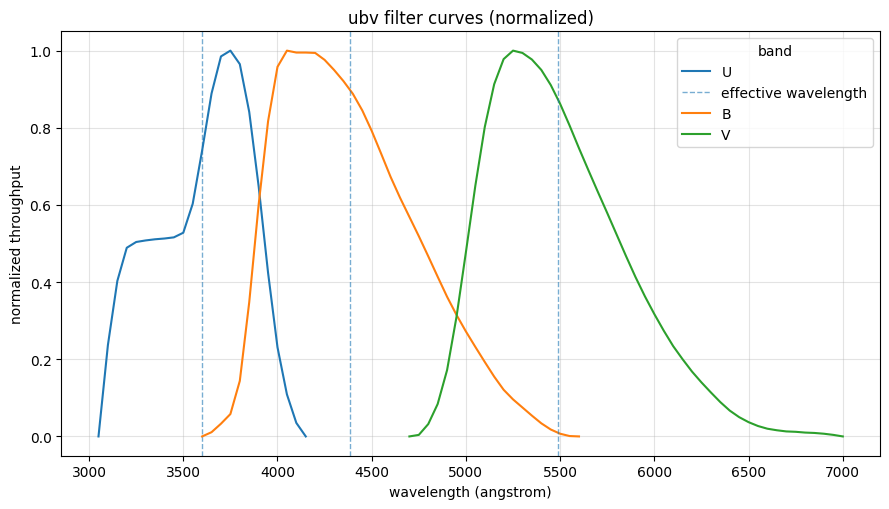

In [3]:
#problem 3 - compute rest-frame ab absolute magnitudes (u, b, v) for all pickles (1998)
#templates and also add color columns u−b and b−v, plus plot the u/b/v filter curves (this was my sanity check)

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#paths and folders
base_dir = Path.cwd()
prob3_dir = base_dir / "Problem3"
prob3_dir.mkdir(parents=True, exist_ok=True)

#where the pickles spectra live and where our tables go
pickles_dir = base_dir / "templates" / "pickles_stars" / "ascii_norm"
table_in = base_dir / "templates" / "pickles_stars" / "Table.dat"
table_out = base_dir / "templates" / "pickles_stars" / "Table_with_AB_UBV.dat"  #tab-separated copy next to templates
table_out_p3 = prob3_dir / "Table_with_AB_UBV.csv"  #cleaner csv in problem3

#filter files
filters_dir = base_dir / "filters"
filter_files = {
    "U": filters_dir / "U_MaizApellaniz.dat",
    "B": filters_dir / "B_MaizApellaniz.dat",
    "V": filters_dir / "V_MaizApellaniz.dat",
}

#if spectra are absolute at 10 pc, we can write absolute mags directly
#otherwise colors still make sense but absolute mags stay nan unless you rescale
spectra_are_absolute = True
distance_pc_for_flux = None  #set to a number if you want to rescale to 10 pc

#constants
c_ang_per_s = 2.99792458e18  #speed of light in angstrom/s
fnu_ab_zero = 3.631e-20  #ab zeropoint in erg s^-1 cm^-2 hz^-1

#p1 helpers
def load_filter_any(path):
    arr = np.loadtxt(path, comments=('#','%','//'))  #works for 2 col or 3+ col
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    ncol = arr.shape[1]
    if ncol >= 3:
        lam_raw = arr[:, 1].astype(float)  #wavelength
        thr = arr[:, 2].astype(float)  #throughput
    elif ncol == 2:
        lam_raw = arr[:, 0].astype(float)  #wavelength
        thr = arr[:, 1].astype(float)  #throughput
    else:
        raise ValueError(f"need 2+ numeric columns, got {ncol}")
    m = np.isfinite(lam_raw) & np.isfinite(thr) & (lam_raw > 0) & (thr >= 0)  #cleanup
    return lam_raw[m], thr[m]

def infer_units_and_to_angstrom(lam_raw):
    if lam_raw.size == 0:
        return lam_raw, "??"
    med = float(np.nanmedian(lam_raw))
    if not np.isfinite(med) or med <= 0:
        return lam_raw, "??"
    if 0.2 <= med < 30.0:
        return lam_raw * 1e4, "micrometer->angstrom"  #micrometers -> angstrom
    elif 200.0 <= med < 3000.0:
        return lam_raw * 10.0, "nanometer->angstrom"  #nanometers -> angstrom
    else:
        return lam_raw, "angstrom"  #already angstrom

#p1 helpers and also print a sanity line
def load_filter(band, path):
    lam_raw, thr = load_filter_any(path)  #parse columns
    lam, unit_note = infer_units_and_to_angstrom(lam_raw)  #to angstrom
    o = np.argsort(lam)  #sort
    lam, thr = lam[o], thr[o]
    tmax = np.nanmax(thr)  #normalize to peak 1 so curves are comparable
    if np.isfinite(tmax) and tmax > 0:
        thr = thr / tmax
    den = np.nansum(thr)  #quick effective wavelength print
    lam_eff = np.nansum(lam * thr) / den if den > 0 else np.nan
    print(f"[filter] {band}: eff lam ≈ {lam_eff:.0f} angstrom; range {lam.min():.0f}-{lam.max():.0f} angstrom; units: {unit_note}")
    return lam, thr

def eff_lambda_and_fwhm(lam, thr):
    if lam.size == 0 or thr.size == 0 or not np.isfinite(thr).any():
        return np.nan, np.nan
    tmax = np.nanmax(thr)
    if not np.isfinite(tmax) or tmax <= 0:
        return np.nan, np.nan
    w = thr / tmax  #normalize
    lam_eff = np.nansum(lam * w) / np.nansum(w)
    mask = w >= 0.5  #fwhm from half max
    fwhm = lam[mask].max() - lam[mask].min() if np.any(mask) else np.nan
    return lam_eff, fwhm

#spectra and ab photometry
#read ascii spectrum, skip comments, return (lam, flux) as numpy arrays
def load_spectrum_ascii(path):
    wl, fl = [], []
    with open(path, "r", errors="ignore") as fh:
        for line in fh:
            s = line.strip()  #trim whitespace
            if not s or s[0] in "#;":  #skip blanks and comment lines
                continue
            parts = s.split()  #split on whitespace
            if len(parts) < 2:  #need at least wavelength and flux
                continue
            try:
                lam = float(parts[0]); val = float(parts[1])  #parse numbers
            except ValueError:
                continue  #bail on any weird non-numeric line
            wl.append(lam); fl.append(val)  #stash our values
    lam = np.asarray(wl, float); flux = np.asarray(fl, float)  #to numpy
    m = np.isfinite(lam) & np.isfinite(flux) & (lam > 0)  #keep sane rows
    lam, flux = lam[m], flux[m]  #apply mask
    o = np.argsort(lam)  #sort by wavelength just in case
    return lam[o], flux[o]  #return clean, sorted arrays

def scale_flux_to_10pc(f_lambda, d_pc):
    return f_lambda * (d_pc / 10.0)**2

def resample_to(lam_src, val_src, lam_ref):
    return np.interp(lam_ref, lam_src, val_src, left=0.0, right=0.0)

def ab_mag_from_spectrum(lam_A, f_lambda, flt_lam_A, flt_thr, photon=True):
    if lam_A.size == 0 or flt_lam_A.size == 0:
        return np.nan
    lam_min = max(lam_A.min(), flt_lam_A.min())
    lam_max = min(lam_A.max(), flt_lam_A.max())
    if lam_max <= lam_min:
        return np.nan
    ngrid = 5000  #fine enough that ubv is sampled well in ln lambda
    lnlam = np.linspace(np.log(lam_min), np.log(lam_max), ngrid)
    lam_g = np.exp(lnlam)
    S = resample_to(flt_lam_A, flt_thr, lam_g)
    f_lam = resample_to(lam_A, f_lambda, lam_g)
    f_nu = f_lam * (lam_g**2) / c_ang_per_s  #convert f_lambda -> f_nu
    S_eff = S * lam_g if photon else S  #photon-counting weight
    dln = np.gradient(lnlam)
    num = np.sum(f_nu * S_eff * dln)
    den = np.sum(S_eff * dln)
    if den <= 0 or num <= 0 or not np.isfinite(num/den):
        return np.nan
    fnu_avg = num / den
    return -2.5 * np.log10(fnu_avg / fnu_ab_zero)

#1) load filters and quick sanity prints
filters = {band: load_filter(band, path) for band, path in filter_files.items()}
for band, (lam, thr) in filters.items():
    lam_eff, fwhm = eff_lambda_and_fwhm(lam, thr)
    print(f"[diag] {band}: eff lam ≈ {lam_eff:.0f} angstrom, fwhm ≈ {fwhm:.0f} angstrom")

#plot the curves so it’s obvious things look reasonable
fig, ax = plt.subplots(figsize=(9.0, 5.2))
labeled_vline = False
for band in ["U", "B", "V"]:
    if band not in filters:
        continue
    lam, thr = filters[band]
    ax.plot(lam, thr, label=band)
    lam_eff, _ = eff_lambda_and_fwhm(lam, thr)
    if np.isfinite(lam_eff):
        ax.axvline(lam_eff, ls="--", lw=1.0, alpha=0.6, label=("effective wavelength" if not labeled_vline else "_nolegend_"))
        labeled_vline = True
ax.set_xlabel("wavelength (angstrom)")
ax.set_ylabel("normalized throughput")
ax.set_title("ubv filter curves (normalized)")
ax.grid(True, alpha=0.35)
ax.legend(title="band")
fig.tight_layout()
out_png = prob3_dir / "filters_UBV.png"
fig.savefig(out_png)
print(f"saved filter plot: {out_png.resolve()}")

#2) load base table (usually: filename, spectral_type, luminosity_class, Teff)
df = pd.read_csv(
    table_in, delim_whitespace=True, comment="#",
    header=None, names=["filename", "spectral_type", "luminosity_class", "Teff"]
)
if str(df.loc[0, "filename"]).lower().startswith("filename"):
    df = df.drop(index=0).reset_index(drop=True)

#set up output columns for mags and colors
for col in ["Mu", "MB", "Mv", "U-B", "B-V"]:
    df[col] = np.nan

#3) loop spectra, compute ab mags and colors
for i, row in df.iterrows():
    fname = str(row["filename"]).strip()
    if not fname.endswith(".ascii"):
        fname += ".ascii"
    spath = pickles_dir / fname
    if not spath.exists():
        print(f"[warn] missing spectrum: {spath}")
        continue
    lam, f_in = load_spectrum_ascii(spath)
    if spectra_are_absolute:
        f10 = f_in  #already absolute at 10 pc
    elif distance_pc_for_flux is not None:
        f10 = scale_flux_to_10pc(f_in, distance_pc_for_flux)
    else:
        f10 = f_in  #unknown scaling, colors still fine
    try:
        mU = ab_mag_from_spectrum(lam, f10, *filters["U"], photon=True)
        mB = ab_mag_from_spectrum(lam, f10, *filters["B"], photon=True)
        mV = ab_mag_from_spectrum(lam, f10, *filters["V"], photon=True)
    except Exception:
        mU = mB = mV = np.nan
    if spectra_are_absolute or (distance_pc_for_flux is not None):
        df.at[i, "Mu"] = mU
        df.at[i, "MB"] = mB
        df.at[i, "Mv"] = mV
    if np.isfinite(mU) and np.isfinite(mB):
        df.at[i, "U-B"] = mU - mB
    if np.isfinite(mB) and np.isfinite(mV):
        df.at[i, "B-V"] = mB - mV

#4) save outputs
out_cols = ["filename", "spectral_type", "luminosity_class", "Teff", "Mu", "MB", "Mv", "U-B", "B-V"]
df[out_cols].to_csv(table_out, sep="\t", index=False)
print(f"saved (tab): {table_out.resolve()}")
df[out_cols].to_csv(table_out_p3, index=False)
print(f"saved (csv): {table_out_p3.resolve()}")


# Problem 4

saved problem 4 plots to C:\Users\tklea\Tufts Masters\Courses\Galactic Astrpohysics\HW1\Problem4


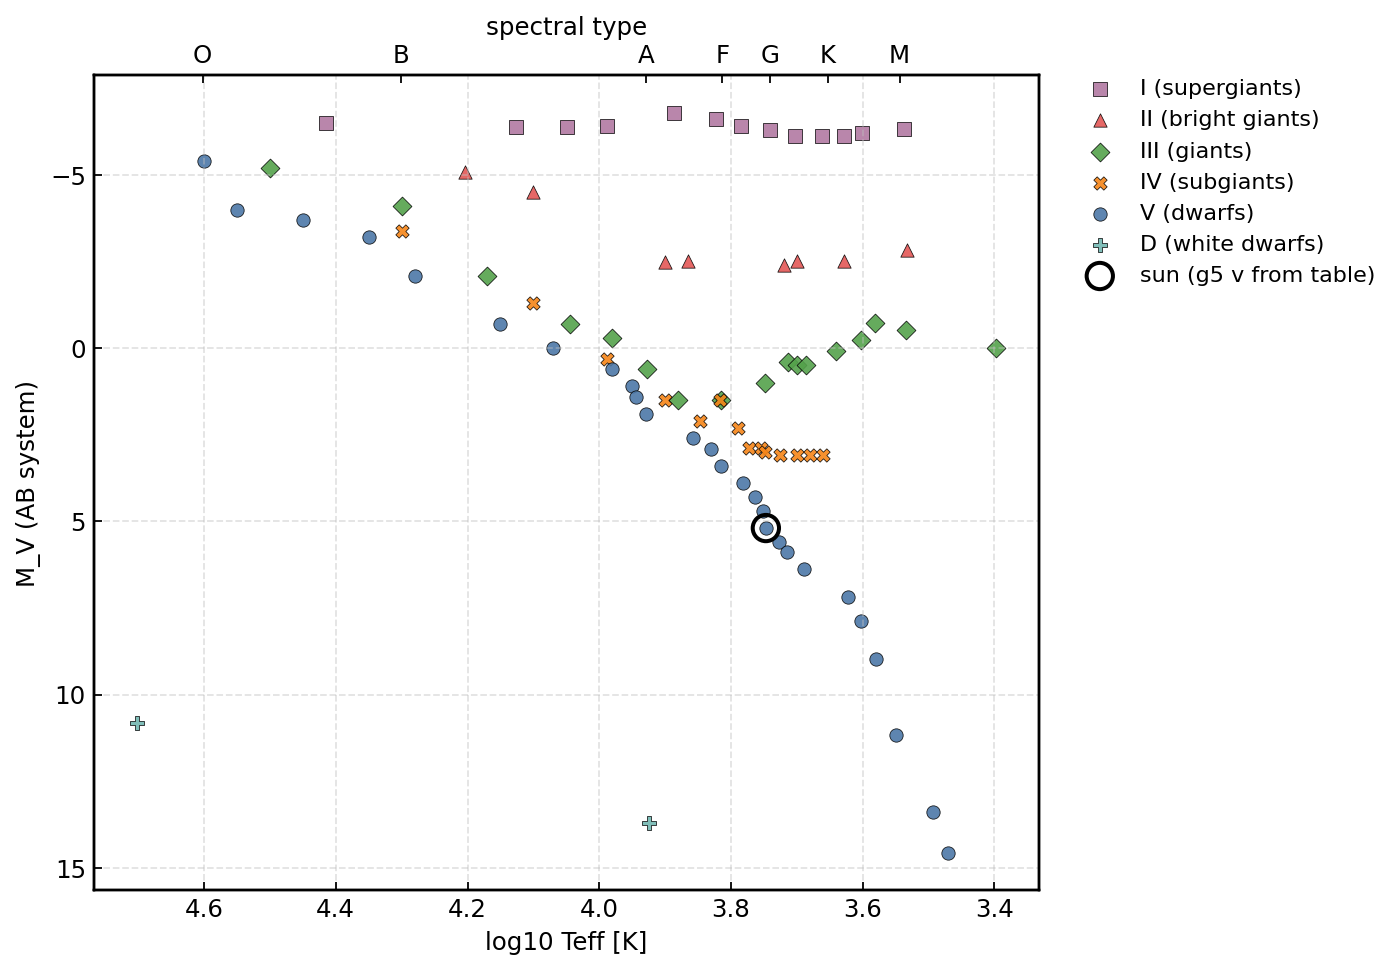

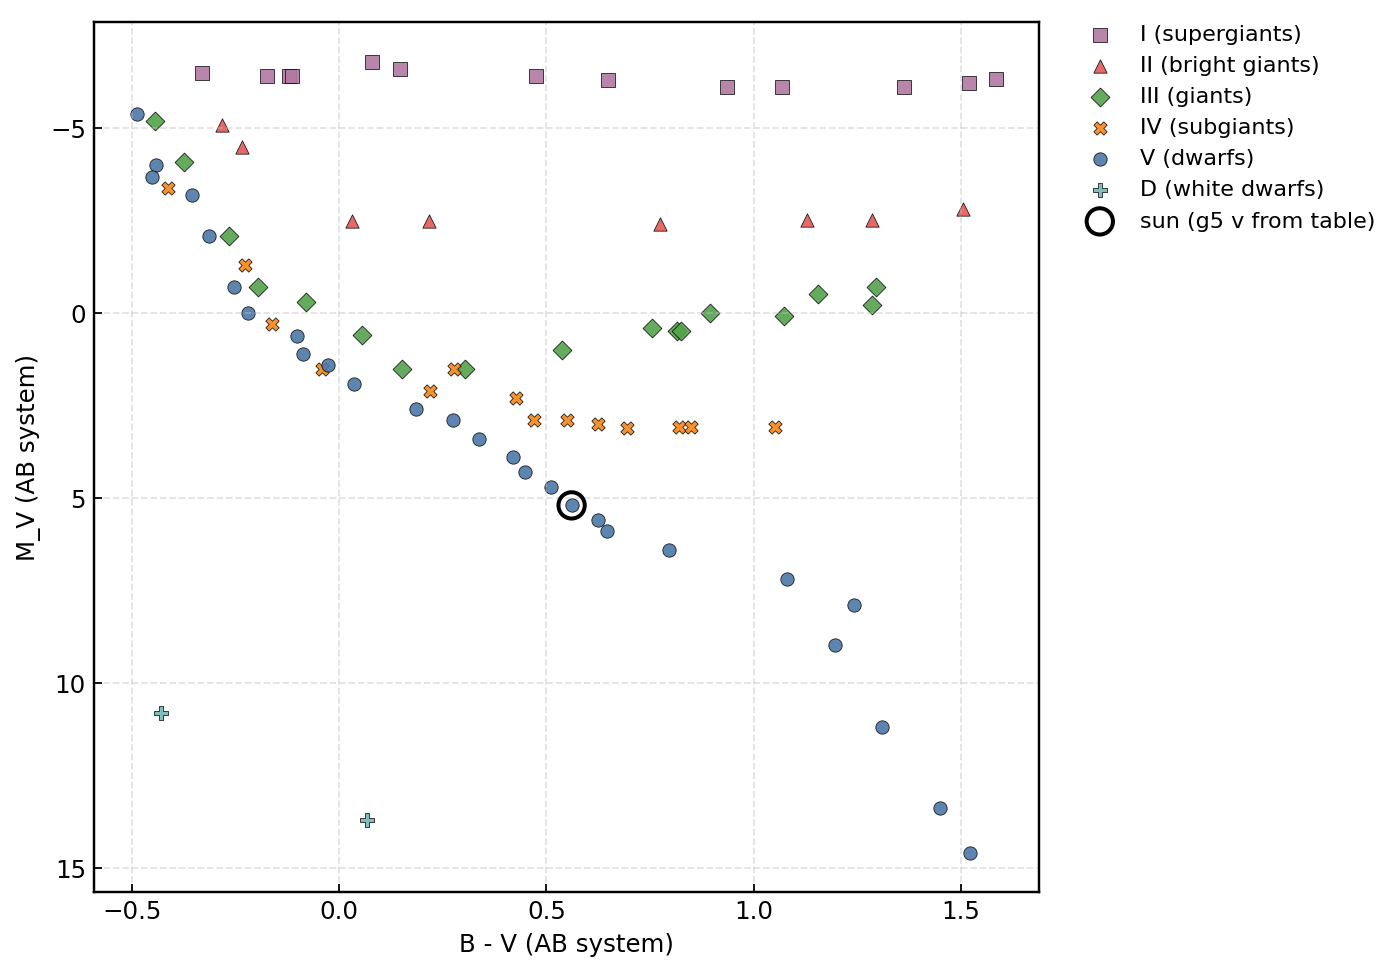

In [4]:
#problem 4 - h–r diagrams from pickles (1998) templates, with sun marked
#
#panels:
#1) m_v vs log10(teff) (bright at top, hot on the left)
#2) m_v vs (b − v) (bright at top, blue on the left)

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#paths and folders
base_dir = Path.cwd()
out_dir = base_dir / "Problem4"
out_dir.mkdir(parents=True, exist_ok=True)

table_file = base_dir / "templates" / "pickles_stars" / "Table_with_AB_UBV.dat"

#marker/color per luminosity class
lc_style = {
    "I":   dict(color="#b279a2", marker="s", label="I (supergiants)"),
    "II":  dict(color="#e45756", marker="^", label="II (bright giants)"),
    "III": dict(color="#54a24b", marker="D", label="III (giants)"),
    "IV":  dict(color="#f58518", marker="X", label="IV (subgiants)"),
    "V":   dict(color="#4c78a8", marker="o", label="V (dwarfs)"),
    "D":   dict(color="#72b7b2", marker="P", label="D (white dwarfs)"),
}
point_size = 36  #a comfy scatter size

#helper: fix messy lc strings like 'iii-iv' or ' g5iii ' to I/II/III/IV/V/D
def primary_lum_class(s):
    if not isinstance(s, str):
        return "OTHER"
    t = s.strip().upper().replace(" ", "")
    for tok in ("III", "II", "IV", "V", "I", "D"):  #check longer tokens first
        if t.startswith(tok) or tok in t:
            return tok
    return "OTHER"

#fallback for the sun if we don’t find a g5 v in the table
sun_fallback = dict(teff=5772.0, Mv=4.83, BminusV=0.65)

#try to grab a g5 v row from the table, return (logT, Mv, B-V) if it exists
def find_sun_from_table(df):
    mask = df["spectral_type"].astype(str).str.upper().str.contains("G5") & \
           df["luminosity_class"].apply(primary_lum_class).eq("V")
    if mask.any():
        row = df.loc[mask].iloc[0]
        logT = np.log10(float(row["Teff"]))
        Mv = float(row["Mv"])
        BmV = float(row["BminusV"]) if "BminusV" in row else float(row["B-V"])
        return logT, Mv, BmV
    return None

#load the table
df = pd.read_csv(table_file, delim_whitespace=True, comment="#")

#if b-v is missing but we have mb and mv, make it
if "B-V" not in df.columns and {"MB", "Mv"}.issubset(df.columns):
    df["B-V"] = pd.to_numeric(df["MB"], errors="coerce") - pd.to_numeric(df["Mv"], errors="coerce")

#make sure everything is numeric
df["Teff"] = pd.to_numeric(df["Teff"], errors="coerce")
df["Mv"] = pd.to_numeric(df["Mv"], errors="coerce")
df["BminusV"] = pd.to_numeric(df["B-V"], errors="coerce")
df["logTeff"] = np.log10(df["Teff"])

#keep only rows with complete stuff for both plots
mask = np.isfinite(df["logTeff"]) & np.isfinite(df["Mv"]) & np.isfinite(df["BminusV"])
df = df.loc[mask].copy()

#add a clean lc column
df["LC"] = df["luminosity_class"].apply(primary_lum_class)

#get sun coordinates from table if possible, else fallback
sun_tuple = find_sun_from_table(df)
if sun_tuple is not None:
    sun_logT, sun_Mv, sun_BV = sun_tuple
    sun_label = "sun (g5 v from table)"
else:
    sun_logT = np.log10(sun_fallback["teff"])
    sun_Mv = sun_fallback["Mv"]
    sun_BV = sun_fallback["BminusV"]
    sun_label = "sun (fallback)"

#plotting defaults
plt.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "font.size": 11,
    "axes.linewidth": 1.1,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "grid.color": "0.75",
})

#plot 1: m_v vs log10(teff)
fig1, ax1 = plt.subplots(figsize=(10.5, 6.2))
for lc, style in lc_style.items():
    sub = df[df["LC"] == lc]
    if len(sub) > 0:
        ax1.scatter(sub["logTeff"], sub["Mv"],s=point_size, color=style["color"], marker=style["marker"],alpha=0.9, edgecolors="k", linewidths=0.35, label=style["label"])

#sun marker as an open circle
ax1.scatter([sun_logT], [sun_Mv], s=140, facecolors="none", edgecolors="k",linewidths=1.8, label=sun_label, zorder=5)

#h–r vibes: bright at top, hot on the left
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_xlim(ax1.get_xlim()[::-1])
ax1.set_xlabel("log10 Teff [K]")
ax1.set_ylabel("M_V (AB system)")
ax1.grid(True, ls="--", lw=0.8, alpha=0.45)
ax1.legend(loc="upper left", bbox_to_anchor=(1.02, 1.02), frameon=False, fontsize=10)

#tiny spectral-type ruler on the top axis
ax_top = ax1.twiny()
sp_types = {"O": 40000, "B": 20000, "A": 8500, "F": 6500, "G": 5500, "K": 4500, "M": 3500}
ticks_logT = [np.log10(T) for T in sp_types.values()]
ax_top.set_xticks(ticks_logT)
ax_top.set_xticklabels(list(sp_types.keys()))
ax_top.set_xlim(ax1.get_xlim())
ax_top.set_xlabel("spectral type")

fig1.tight_layout(rect=(0, 0, 0.85, 1))
fig1.savefig(out_dir / "HR1_Mv_vs_logTeff.png")

#plot 2: m_v vs (b − v)
fig2, ax2 = plt.subplots(figsize=(10.5, 6.2))
for lc, style in lc_style.items():
    sub = df[df["LC"] == lc]
    if len(sub) > 0:
        ax2.scatter(sub["BminusV"], sub["Mv"],s=point_size, color=style["color"], marker=style["marker"],alpha=0.9, edgecolors="k", linewidths=0.35, label=style["label"])

#sun again
ax2.scatter([sun_BV], [sun_Mv], s=140, facecolors="none", edgecolors="k",linewidths=1.8, label=sun_label, zorder=5)

#same h–r convention for y
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_xlabel("B - V (AB system)")
ax2.set_ylabel("M_V (AB system)")
ax2.grid(True, ls="--", lw=0.8, alpha=0.45)
ax2.legend(loc="upper left", bbox_to_anchor=(1.02, 1.02), frameon=False, fontsize=10)

fig2.tight_layout(rect=(0, 0, 0.85, 1))
fig2.savefig(out_dir / "HR2_Mv_vs_BminusV.png")

print(f"saved problem 4 plots to {out_dir.resolve()}")


# Problem 5

[filter] U: eff lam ≈ 3599 angstrom; range 3050-4150 angstrom; units: angstrom
[filter] B: eff lam ≈ 4386 angstrom; range 3600-5600 angstrom; units: angstrom
[filter] V: eff lam ≈ 5491 angstrom; range 4700-7000 angstrom; units: angstrom
[diag] U: eff lam ≈ 3599 angstrom, fwhm ≈ 650 angstrom
[diag] B: eff lam ≈ 4386 angstrom, fwhm ≈ 850 angstrom
[diag] V: eff lam ≈ 5491 angstrom, fwhm ≈ 750 angstrom


C:\Users\tklea\AppData\Local\Temp\ipykernel_36916\580930630.py:181: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(sub["B-V"].values, sub["U-B"].values,c=sub["logTeff"].values, cmap=cmap, norm=norm,s=lc_sizes.get(lc_key, 44),marker=lc_markers.get(lc_key, "o"),edgecolors="k", linewidths=0.5, alpha=0.95, zorder=2)


saved: C:\Users\tklea\Tufts Masters\Courses\Galactic Astrpohysics\HW1\Problem5\ColorColor_UBvsBV_custom.png


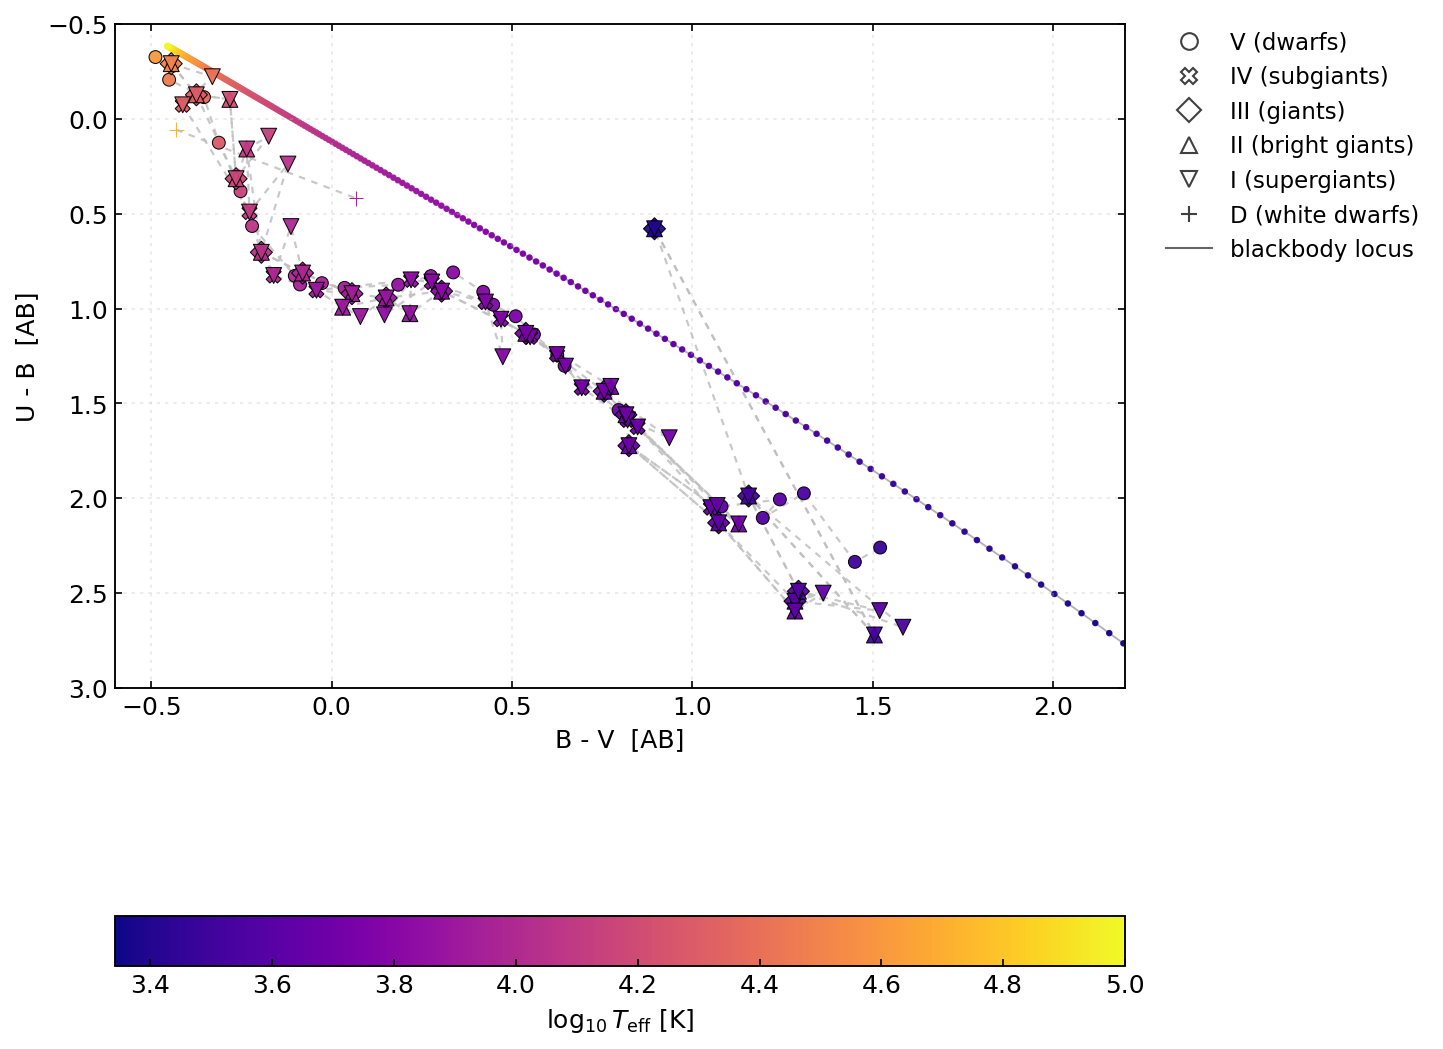

In [5]:
#problem 5 — color–color diagram: u–b vs b–v (pickles stars) and blackbody locus

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#paths
base_dir = Path.cwd()
out_dir = base_dir / "Problem5"
out_dir.mkdir(parents=True, exist_ok=True)

table_file = base_dir / "templates" / "pickles_stars" / "Table_with_AB_UBV.dat"
filters_dir = base_dir / "filters"
filter_files = {
    "U": filters_dir / "U_MaizApellaniz.dat",
    "B": filters_dir / "B_MaizApellaniz.dat",
    "V": filters_dir / "V_MaizApellaniz.dat",
}

#constants
c_ang_per_s = 2.99792458e18  #angstrom/s
c_cgs = 2.99792458e10 #cm/s
h_erg_s = 6.62607015e-27
k_B = 1.380649e-16
fnu_ab_zero = 3.631e-20 #erg s^-1 cm^-2 hz^-1

#helpers (a bit of a merge of two of them because I am tired of copying and pasting my above functions)
def load_filter(band, path):
    #assume files are: index, lambda, throughput (or just lambda, throughput)
    arr = np.loadtxt(path, comments=('#','%','//'))
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    ncol = arr.shape[1]
    if ncol >= 3:
        lam_raw = arr[:, 1].astype(float)
        thr = arr[:, 2].astype(float)
    elif ncol == 2:
        lam_raw = arr[:, 0].astype(float)
        thr = arr[:, 1].astype(float)
    else:
        raise ValueError(f"need 2+ numeric columns, got {ncol}")
    m = np.isfinite(lam_raw) & np.isfinite(thr) & (lam_raw > 0) & (thr >= 0)
    lam_raw, thr = lam_raw[m], thr[m]
    if lam_raw.size < 5:
        raise ValueError("not enough valid rows after cleaning")
    med = float(np.nanmedian(lam_raw))  #unit guess to angstrom
    if 0.2 <= med < 30.0:
        lam = lam_raw * 1e4
        unit_note = "micrometer->angstrom"
    elif 200.0 <= med < 3000.0:
        lam = lam_raw * 10.0
        unit_note = "nanometer->angstrom"
    else:
        lam = lam_raw
        unit_note = "angstrom"
    o = np.argsort(lam)
    lam, thr = lam[o], thr[o]
    tmax = np.nanmax(thr)
    if np.isfinite(tmax) and tmax > 0:
        thr = thr / tmax
    den = np.nansum(thr)
    lam_eff = np.nansum(lam * thr) / den if den > 0 else np.nan
    print(f"[filter] {band}: eff lam ≈ {lam_eff:.0f} angstrom; range {lam.min():.0f}-{lam.max():.0f} angstrom; units: {unit_note}")
    return lam, thr

def resample_to(lam_src, val_src, lam_ref):
    #interpolate values onto new wavelength grid, zero outside
    return np.interp(lam_ref, lam_src, val_src, left=0.0, right=0.0)

def ab_mag_from_spectrum(lam_A, f_lambda, flt_lam_A, flt_thr, photon=True):
    #compute ab mag by averaging f_nu over the band (photon-weighted)
    if lam_A.size == 0 or flt_lam_A.size == 0:
        return np.nan 
    lam_min = max(lam_A.min(), flt_lam_A.min())  #overlap start
    lam_max = min(lam_A.max(), flt_lam_A.max())  #overlap end
    if lam_max <= lam_min:
        return np.nan
    ngrid = 5000  #dense log-lambda grid so integration is smooth
    lnlam = np.linspace(np.log(lam_min), np.log(lam_max), ngrid)
    lam_g = np.exp(lnlam)
    S = resample_to(flt_lam_A, flt_thr, lam_g)  #filter on common grid
    f_lam = resample_to(lam_A, f_lambda, lam_g)  #spectrum on common grid
    f_nu = f_lam * (lam_g**2) / c_ang_per_s
    S_eff = S * lam_g if photon else S #photon-counting weight
    dln = np.gradient(lnlam)  #differential spacing in ln lambda
    num = np.sum(f_nu * S_eff * dln) 
    den = np.sum(S_eff * dln)
    if den <= 0 or num <= 0 or not np.isfinite(num/den):
        return np.nan 
    fnu_avg = num / den  #band-averaged f_nu
    return -2.5 * np.log10(fnu_avg / fnu_ab_zero)  #ab magnitude


def planck_f_lambda(lam_A, T):
    #planck function in f_lambda with wavelength in angstrom, temp in kelvin
    lam_cm = lam_A * 1e-8
    x = (h_erg_s * c_cgs) / (lam_cm * k_B * T)
    x = np.clip(x, 1e-6, 700.0)  #keep exp() sane!!
    B_lambda_per_cm = (2.0 * h_erg_s * c_cgs**2 / lam_cm**5) / (np.exp(x) - 1.0)
    return B_lambda_per_cm * 1e-8  #per angstrom

#load our table
df = pd.read_csv(table_file, sep=r"\s+|\t", engine="python", comment="#")
if "filename" not in df.columns:
    df = pd.read_csv(table_file, delim_whitespace=True, comment="#", header=None,names=["filename","spectral_type","luminosity_class","Teff","Mu","MB","Mv","U-B","B-V"])
if str(df.iloc[0,0]).lower().startswith("filename"):
    df = df.drop(index=0).reset_index(drop=True)

#ensure colors are present
if "B-V" not in df.columns and {"MB","Mv"}.issubset(df.columns):
    df["B-V"] = pd.to_numeric(df["MB"], errors="coerce") - pd.to_numeric(df["Mv"], errors="coerce")
df["Teff"] = pd.to_numeric(df["Teff"], errors="coerce")
df["U-B"] = pd.to_numeric(df["U-B"], errors="coerce")
df["B-V"] = pd.to_numeric(df["B-V"], errors="coerce")
df["logTeff"] = np.log10(df["Teff"])
df = df[["spectral_type","luminosity_class","Teff","logTeff","U-B","B-V"]].dropna().copy()

#load filters and diags
filters = {band: load_filter(band, path) for band, path in filter_files.items()}
for band, (lam, thr) in filters.items():
    tmax = np.nanmax(thr)
    w = thr / tmax if np.isfinite(tmax) and tmax > 0 else thr
    lam_eff = np.nansum(lam * w) / np.nansum(w) if np.nansum(w) > 0 else np.nan
    half = w >= 0.5
    fwhm = (lam[half].max() - lam[half].min()) if np.any(half) else np.nan
    print(f"[diag] {band}: eff lam ≈ {lam_eff:.0f} angstrom, fwhm ≈ {fwhm:.0f} angstrom")

#blackbody locus
lam_grid = np.exp(np.linspace(np.log(2000.0), np.log(9000.0), 6000)) #dense grid over optical
T_vals = np.logspace(np.log10(2200.0), np.log10(100000.0), 250) #wide temp range
bb = []
for T in T_vals:
    f_lam = planck_f_lambda(lam_grid, T)
    mU = ab_mag_from_spectrum(lam_grid, f_lam, *filters["U"], photon=True)
    mB = ab_mag_from_spectrum(lam_grid, f_lam, *filters["B"], photon=True)
    mV = ab_mag_from_spectrum(lam_grid, f_lam, *filters["V"], photon=True)
    if np.all(np.isfinite([mU, mB, mV])):
        bb.append((T, mU - mB, mB - mV))
bb = np.array(bb) if len(bb) else np.empty((0,3))

#plot!
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.size": 12,
    "axes.linewidth": 0.9,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "grid.linestyle": (0, (2, 3)),
    "grid.alpha": 0.35,
})

cmap = plt.cm.plasma
vmin = float(min(df["logTeff"].min(), np.log10(bb[:,0]).min() if bb.size else df["logTeff"].min()))
vmax = float(max(df["logTeff"].max(), np.log10(bb[:,0]).max() if bb.size else df["logTeff"].max()))
norm = plt.Normalize(vmin=vmin, vmax=vmax)

lc_order = ["V","IV","III","II","I","D"]
lc_markers = {"V":"o", "IV":"X", "III":"D", "II":"^", "I":"v", "D":"+"}
lc_sizes = {"V":38, "IV":52, "III":56, "II":58, "I":58, "D":50}

fig, ax = plt.subplots(figsize=(9.8, 7.2))

#connect sequences per luminosity class (hot -> cool)
for lc_key in lc_order:
    m = df["luminosity_class"].astype(str).str.upper().str.startswith(lc_key)
    sub = df.loc[m].copy()
    if len(sub) < 2:
        continue
    sub = sub.sort_values("Teff", ascending=False)
    ax.plot(sub["B-V"].values, sub["U-B"].values,linestyle=(0, (3, 3)), color="0.75", linewidth=1.05, alpha=0.85, zorder=1)

#scatter stars
for lc_key in lc_order:
    m = df["luminosity_class"].astype(str).str.upper().str.startswith(lc_key)
    sub = df.loc[m]
    if len(sub) == 0:
        continue
    ax.scatter(sub["B-V"].values, sub["U-B"].values,c=sub["logTeff"].values, cmap=cmap, norm=norm,s=lc_sizes.get(lc_key, 44),marker=lc_markers.get(lc_key, "o"),edgecolors="k", linewidths=0.5, alpha=0.95, zorder=2)

#blackbody locus
if bb.size:
    bb_logT = np.log10(bb[:,0])
    ax.plot(bb[:,2], bb[:,1], color="k", linewidth=0.9, alpha=0.30, zorder=0, label="blackbody locus")
    ax.scatter(bb[:,2], bb[:,1], c=bb_logT, cmap=cmap, norm=norm,s=18, marker=".", alpha=0.95, zorder=1)

#axes
ax.set_xlabel("B - V  [AB]")
ax.set_ylabel("U - B  [AB]")
ax.set_xlim(-0.6, 2.2)
ax.set_ylim(3.0, -0.5)  #bluer (smaller u−b) at top
ax.grid(True)
ax.tick_params(direction="in", top=True, right=True)

#legend (classes and blackbody) outside
lc_labels = {
    "V":  "V (dwarfs)",
    "IV": "IV (subgiants)",
    "III":"III (giants)",
    "II": "II (bright giants)",
    "I":  "I (supergiants)",
    "D":  "D (white dwarfs)",
}
legend_handles = [Line2D([0],[0], marker=lc_markers[k], linestyle="",color="0.2", markerfacecolor="none", markeredgecolor="0.25",markersize=8, label=lc_labels.get(k, k)) for k in lc_order]
if bb.size:
    legend_handles.append(Line2D([0],[0], color="k", lw=1.0, alpha=0.6, label="blackbody locus"))
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1.02, 1.02),frameon=False, fontsize=11)

#colorbar for log teff
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cb = fig.colorbar(mappable, ax=ax, orientation="horizontal", pad=0.24, fraction=0.06)
cb.set_label(r"$\log_{10} T_{\rm eff}\ \mathrm{[K]}$")
cb.ax.tick_params(direction="in")

plt.tight_layout()
out_path = out_dir / "ColorColor_UBvsBV_custom.png"
plt.savefig(out_path)
print(f"saved: {out_path.resolve()}")


**Discussion  (Problem 5)**  
The $u-b$ vs. $b-v$ map shows the classic stellar track: hot, early-type stars (yellow) sit up/left and slide down/right toward cooler (purple) types. There’s a sharp knee near $b\!-\!v \simeq 0$ (around A0) where the Balmer jump makes $u-b$ change quickly. Different luminosity classes follow similar paths but are offset vertically: lower gravity (giants/supergiants) tends to enhance the Balmer jump and other wavelength-dependent opacity, so at the same $b\!-\!v$ they appear redder in $u-b$ than dwarfs; white dwarfs cluster at the extreme blue end. The blackbody locus runs bluer in $u-b$ than real stars at cooler $T_{\rm eff}$ because real stellar atmospheres introduce extra, wavelength-dependent absorption in the near-UV/blue, which depresses the $U$-band more than $B$ and shifts colors redward relative to a smooth blackbody. In general, the motion along the sequence mostly tracks $T_{\rm eff}$ with the horizontal spread being set mainly by intrinsic color/temperature (broadened by interstellar reddening) and the vertical spread reflecting surface gravity and overall composition.

# Problem 6

[filter] U: eff lam ≈ 3599 angstrom; range 3050-4150 angstrom; units: angstrom
[filter] V: eff lam ≈ 5491 angstrom; range 4700-7000 angstrom; units: angstrom
[filter] K: eff lam ≈ 21620 angstrom; range 19340-23680 angstrom; units: angstrom


C:\Users\tklea\AppData\Local\Temp\ipykernel_36916\2326007072.py:183: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(table_in, sep=r"\s+|\t", comment="#")


saved table: C:\Users\tklea\Tufts Masters\Courses\Galactic Astrpohysics\HW1\Problem6\Table_with_BCs.dat
saved combined figure: C:\Users\tklea\Tufts Masters\Courses\Galactic Astrpohysics\HW1\Problem6\BC_three_panel.png


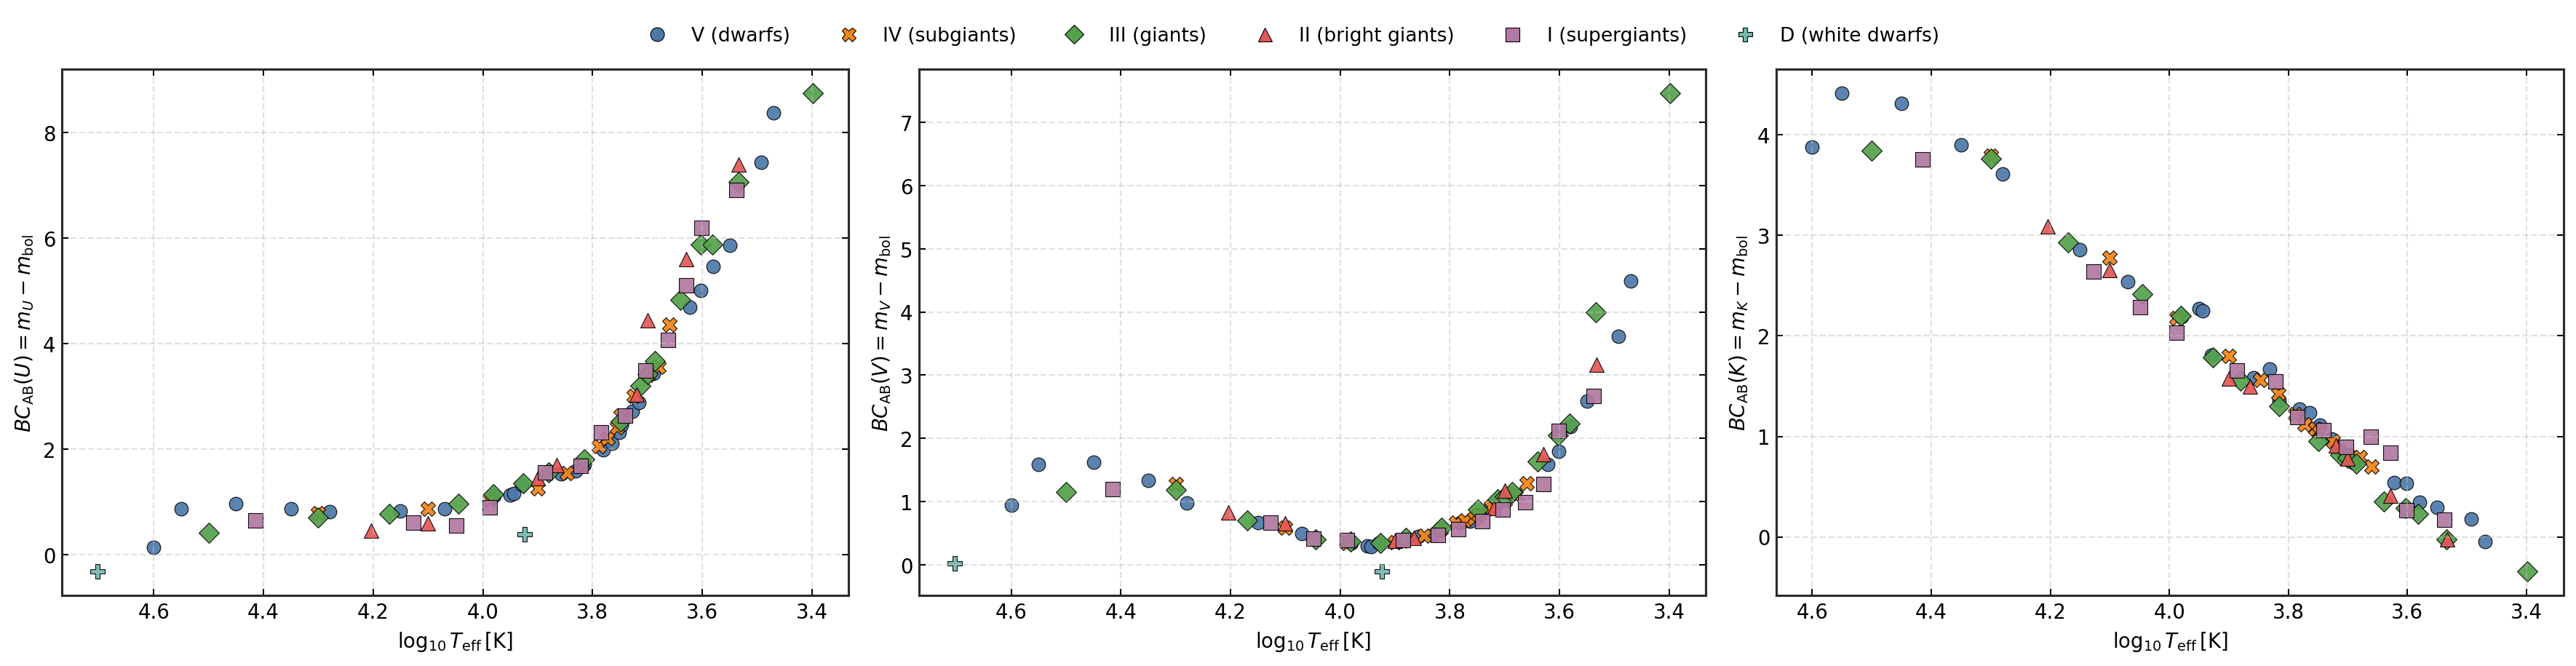

In [6]:
#problem 6 - bolometric corrections (u, v, k) in the ab system (classy plots, no bb tails)

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#paths and folders
base_dir = Path.cwd()
out_dir = base_dir / "Problem6"
out_dir.mkdir(parents=True, exist_ok=True)

pickles_dir = base_dir / "templates" / "pickles_stars" / "ascii_norm"
table_in = base_dir / "templates" / "pickles_stars" / "Table_with_AB_UBV.dat"
out_table = out_dir / "Table_with_BCs.dat"

filters_dir = base_dir / "filters"
filter_files = {
    "U": filters_dir / "U_MaizApellaniz.dat",
    "V": filters_dir / "V_MaizApellaniz.dat",
    "K": filters_dir / "K_2mass.dat",
}

#constants
c_a_per_s = 2.99792458e18  #speed of light in angstrom per second
ab_zp = 48.60  #m_ab = -2.5 log10(<f_nu>) - 48.60

#simple filter loader
def load_filter(band: str, path: Path):
    #read 2 or 3+ numeric columns and guess wavelength units
    arr = np.loadtxt(path, comments=('#','%','//'))
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    if arr.shape[1] >= 3:
        lam_raw = arr[:, 1].astype(float)  #wavelength
        thr = arr[:, 2].astype(float) #throughput
    elif arr.shape[1] == 2:
        lam_raw = arr[:, 0].astype(float)
        thr = arr[:, 1].astype(float)
    else:
        raise ValueError(f"need 2+ numeric columns in {path}")
    
    #clean
    m = np.isfinite(lam_raw) & np.isfinite(thr) & (lam_raw > 0) & (thr >= 0)
    lam_raw, thr = lam_raw[m], thr[m]
    if lam_raw.size < 5:
        raise ValueError("not enough valid rows after cleaning")

    #really rough unit guess -> angstrom
    med = float(np.nanmedian(lam_raw))
    if 0.2 <= med < 30.0:
        lam = lam_raw * 1e4  #micrometer -> angstrom
        unit_note = "micrometer->angstrom"
    elif 200.0 <= med < 3000.0:
        lam = lam_raw * 10.0  #nanometer -> angstrom
        unit_note = "nanometer->angstrom"
    else:
        lam = lam_raw
        unit_note = "angstrom"

    #sort and normalize peak to 1
    o = np.argsort(lam)
    lam, thr = lam[o], thr[o]
    tmax = np.nanmax(thr)
    if np.isfinite(tmax) and tmax > 0:
        thr = thr / tmax

    #quick sanity print
    den = np.nansum(thr)
    lam_eff = np.nansum(lam * thr) / den if den > 0 else np.nan
    print(f"[filter] {band}: eff lam ≈ {lam_eff:.0f} angstrom; range {lam.min():.0f}-{lam.max():.0f} angstrom; units: {unit_note}")

    return lam, thr

#sed helpers
def load_spectrum_ascii(path: Path):
    #read wavelength (angstrom) and f_lambda, ignore comments
    wl, fl = [], []
    with open(path, "r", errors="ignore") as fh:
        for line in fh:
            s = line.strip()
            if not s or s[0] in "#;":
                continue
            parts = s.split()
            if len(parts) < 2:
                continue
            try:
                wl.append(float(parts[0])); fl.append(float(parts[1]))
            except ValueError:
                continue
    lam = np.asarray(wl, float); f = np.asarray(fl, float)
    m = np.isfinite(lam) & np.isfinite(f) & (lam > 0)
    lam, f = lam[m], f[m]
    o = np.argsort(lam)
    return lam[o], f[o]

def ab_mag_from_spectrum(lam_s, f_lam, fl_lam, fl_thr):
    #ab mag
    #quick sanity, need a few points in both the spectrum and the filter
    if lam_s.size < 5 or fl_lam.size < 5:
        return np.nan
    #find the wavelength overlap
    lo = max(lam_s.min(), fl_lam.min())
    hi = min(lam_s.max(), fl_lam.max())
    if hi <= lo:
        return np.nan  #no overlap, no photometry
    #restrict to the overlap slice
    m = (fl_lam >= lo) & (fl_lam <= hi)
    lam = fl_lam[m].astype(float)
    if lam.size < 5:
        return np.nan
    #grab throughput over the same slice and normalize its peak to 1
    S = fl_thr[m].astype(float)
    if not np.isfinite(np.nanmax(S)) or np.nanmax(S) <= 0:
        return np.nan
    S = S / np.nanmax(S)
    #interpolate the spectrum onto the filter's lambda grid
    f = np.interp(lam, lam_s, f_lam, left=0.0, right=0.0)
    f_nu = f * (lam**2) / c_a_per_s
    #average in ln lambda per ab definition
    lnlam = np.log(lam)
    num = np.trapz(S * f_nu, lnlam)
    den = np.trapz(S, lnlam)
    if den <= 0 or num <= 0 or not np.isfinite(num/den):
        return np.nan
    #convert band-averaged f_nu to ab mag
    return -2.5 * np.log10(num/den) - ab_zp


def mbol_ab_from_spectrum(lam, f_lam):
    #ab bolometric mag by integrating f_nu over ln lambda
    #clean inputs and keep only finite, positive wavelengths
    lam = np.asarray(lam, float)
    f_lam = np.asarray(f_lam, float)
    m = np.isfinite(lam) & np.isfinite(f_lam) & (lam > 0)
    lam, f_lam = lam[m], f_lam[m]
    if lam.size < 5:
        return np.nan
    #sort by wavelength just to be safe
    o = np.argsort(lam)
    lam, f_lam = lam[o], f_lam[o]
    f_nu = f_lam * (lam**2) / c_a_per_s
    #integrate f_nu over ln lambda
    lnlam = np.log(lam)
    I = np.trapz(f_nu, lnlam)
    if not np.isfinite(I) or I <= 0:
        return np.nan
    #turn that integral into an ab-style bolometric magnitude
    return -2.5 * np.log10(I) - ab_zp

#lum class parsing
def primary_lc(s: str) -> str:
    #normalize messy lc strings into i/ii/iii/iv/v/d
    if not isinstance(s, str):
        return "OTHER"
    t = s.strip().upper().replace(" ", "")
    for tok in ("III", "II", "IV", "V", "I", "D"):
        if t.startswith(tok) or f"{tok}" in t:
            return tok
    return "OTHER"

#class styling
lc_style = {
    "V":   dict(color="#4c78a8", marker="o", label="V (dwarfs)",         size=56),
    "IV":  dict(color="#f58518", marker="X", label="IV (subgiants)",     size=64),
    "III": dict(color="#54a24b", marker="D", label="III (giants)",       size=62),
    "II":  dict(color="#e45756", marker="^", label="II (bright giants)", size=64),
    "I":   dict(color="#b279a2", marker="s", label="I (supergiants)",    size=64),
    "D":   dict(color="#72b7b2", marker="P", label="D (white dwarfs)",   size=64),
}

#load filters that exist
filters = {}
for band, path in filter_files.items():
    if path.exists():
        filters[band] = load_filter(band, path)
    else:
        print(f"[warn] missing filter for {band}: {path}")
if not {"U","V"}.issubset(filters):
    raise RuntimeError("need at least u and v filters")

#read the p3 table
df = pd.read_csv(table_in, sep=r"\s+|\t", comment="#")
if "filename" not in df.columns:
    df = pd.read_csv(
        table_in, delim_whitespace=True, comment="#", header=None,
        names=["filename","spectral_type","luminosity_class","Teff","Mu","MB","Mv","U-B","B-V"]
    )
if str(df.iloc[0,0]).lower().startswith("filename"):
    df = df.drop(index=0).reset_index(drop=True)

#prep outputs
for col in ["mU","mV","mK","mBol","BC_U","BC_V","BC_K"]:
    df[col] = np.nan
df["LC"] = df["luminosity_class"].apply(primary_lc)
df["Teff"] = pd.to_numeric(df["Teff"], errors="coerce")
df["logTeff"] = np.log10(df["Teff"])

#compute mags and bcs
mU, mV, mK, mBol = [], [], [], []
for _, row in df.iterrows():
    fname = str(row["filename"]).strip()
    if not fname.endswith(".ascii"):
        fname += ".ascii"
    spath = pickles_dir / fname
    if not spath.exists():
        mU.append(np.nan); mV.append(np.nan); mK.append(np.nan); mBol.append(np.nan)
        continue

    lam, f = load_spectrum_ascii(spath)
    mU.append(ab_mag_from_spectrum(lam, f, *filters["U"]))
    mV.append(ab_mag_from_spectrum(lam, f, *filters["V"]))
    if "K" in filters:
        mK.append(ab_mag_from_spectrum(lam, f, *filters["K"]))
    else:
        mK.append(np.nan)
    mBol.append(mbol_ab_from_spectrum(lam, f))

df["mU"], df["mV"], df["mK"], df["mBol"] = mU, mV, mK, mBol
df["BC_U"] = df["mU"] - df["mBol"]
df["BC_V"] = df["mV"] - df["mBol"]
if "mK" in df.columns:
    df["BC_K"] = df["mK"] - df["mBol"]

#save table
keep = ["filename","spectral_type","luminosity_class","Teff","mU","mV","mK","mBol","BC_U","BC_V","BC_K"]
keep = [c for c in keep if c in df.columns]
df[keep].to_csv(out_table, sep="\t", index=False)
print(f"saved table: {out_table.resolve()}")

#plot with class styling
plt.rcParams.update({
    "font.size": 11,
    "axes.linewidth": 1.25,
    "axes.edgecolor": "#2b2b2b",
    "xtick.direction": "in",
    "ytick.direction": "in",
    "grid.color": "0.75",
})

panels = [("BC_U", r"$BC_{\rm AB}(U)=m_U-m_{\rm bol}$"),("BC_V", r"$BC_{\rm AB}(V)=m_V-m_{\rm bol}$")]
if "BC_K" in df.columns and np.isfinite(df["BC_K"]).any():
    panels.append(("BC_K", r"$BC_{\rm AB}(K)=m_K-m_{\rm bol}$"))

ncols = len(panels)
fig, axes = plt.subplots(1, ncols, figsize=(6.6*ncols, 5.2), dpi=180, sharey=False)
if ncols == 1:
    axes = [axes]

for ax, (ycol, ylabel) in zip(axes, panels):
    for lc, style in lc_style.items():
        sub = df[(df["LC"] == lc) & np.isfinite(df[ycol]) & np.isfinite(df["logTeff"])]
        if not len(sub):
            continue
        ax.scatter(sub["logTeff"], sub[ycol],s=style["size"], color=style["color"], marker=style["marker"],alpha=0.92, edgecolors="black", linewidths=0.45,label=style["label"])
    #hot on the left, same look as before
    ax.set_xlabel(r"$\log_{10} T_{\rm eff}\,[\mathrm{K}]$")
    ax.set_ylabel(ylabel)
    ax.grid(True, ls="--", lw=0.9, alpha=0.45)
    xl = ax.get_xlim()
    if xl[0] < xl[1]:
        ax.set_xlim(xl[::-1])
    ax.tick_params(direction="in", top=True, right=True)

#shared legend on top
handles, labels = [], []
for lc in ("V","IV","III","II","I","D"):
    if lc in lc_style:
        handles.append(plt.Line2D([0],[0],marker=lc_style[lc]["marker"], linestyle="",markersize=7.6, markerfacecolor=lc_style[lc]["color"],markeredgecolor="black", markeredgewidth=0.45,color="none"))
        labels.append(lc_style[lc]["label"])
fig.legend(handles, labels, loc="upper center", ncol=min(6, len(handles)),
           frameon=False, fontsize=10.6, borderaxespad=1.0)

fig.tight_layout(rect=(0, 0, 1, 0.92))
out_png = out_dir / "BC_three_panel.png"
fig.savefig(out_png)
print(f"saved combined figure: {out_png.resolve()}")


**Discussion (Problem 6)**  
Here we use $BC_X \equiv m_X - m_{\rm bol}$ in the AB system, so a **larger (more positive) BC** means the band is **fainter** than the bolometric magnitude and therefore captures a smaller fraction of the star’s total flux.

- **U band:** $BC_{\rm AB}(U)$ is small for hot stars and rises steeply toward cooler types. Cool stars emit little in the near-UV, so $m_U \gg m_{\rm bol}$ and the correction becomes large and positive.

- **V band:** $BC_{\rm AB}(V)$ shows a shallow, U-shaped trend: it is minimal near solar-like $T_{\rm eff}$ ($\log_{10} T_{\rm eff} \approx 3.76$) and grows toward both the hot and cool ends.

- **K band:** $BC_{\rm AB}(K)$ is largest for hot stars and declines toward zero (sometimes slightly negative) for cool stars, where the infrared carries a large share of the luminosity and $K$ becomes a good proxy for bolometric output.

- **Luminosity class:** Class-to-class differences are modest compared to the temperature trend, but some scatter/offsets appear; gravity, composition, and template specifics can tweak the SED shape.

Overall, temperature is the primary driver of $BC_X$: $U$ grows strongly toward cooler $T_{\rm eff}$, $V$ stays relatively small near G-types, and $K$ shrinks toward cool stars.


# Problem 7

In [7]:
#problem 7 — distance modulus
#goal: how far away could the sun still be seen with the naked eye?
#given:
#  - absolute v-band magnitude of the sun: m_v_abs = 4.83
#  - naked-eye limiting apparent magnitude: m_limit = 6.0
#assumption: no bolometric correction drama here, we’re just doing v band

import numpy as np 

def visible_distance(m_v_abs=4.83, m_limit=6.0):
    #compute the max distance (in parsecs) where the sun would still be visible
    #distance modulus basics: m - M = 5 * log10(d / 10 pc)
    #solve for distance: d = 10 * 10 ** ((m - M) / 5)
    dm = m_limit - m_v_abs 
    d_pc = 10 * 10**(dm / 5.0)     
    return d_pc

d_pc = visible_distance()
d_ly = d_pc * 3.26156 

print("problem 7 — distance modulus")
print("-----------------------------")
print(f"answer: the sun would be visible out to ~{d_pc:.2f} parsecs "
      f"(≈ {d_ly:.2f} light-years).")


problem 7 — distance modulus
-----------------------------
answer: the sun would be visible out to ~17.14 parsecs (≈ 55.90 light-years).
